# Mirakl Technical Test

## Introduction:

On an e-commerce site, it is crucial that products are categorized correctly. Incorrect categorization can lead to products being invisible to buyers and create a poor user experience, especially when large quantities of products are misplaced in the wrong category.

Guidelines:
- Analyze the data and describe some possible classification algorithms for such a dataset.
- Choose and implement at least one of these algorithms using the training set (data_train.csv) and perform a prediction on the provided test set (data_test.csv). Specify the chosen metrics. Explain your steps.
- Conduct a complete analysis of the obtained results.
- Do not use the category hierarchy as an explanatory variable.

Objectives:
- A structured and concise presentation
- Insightful data analysis and relevant modeling

Instructions:
- Data files must be stored in a "data" directory

## Exploratory Data Analysis (EDA)

### Insights:

<u>Dataset Size:</u> 
- The dataset contains 241,483 entries, which is reasonable for applying simple models with fewer parameters that should suffice for effective modeling.
  
<u>Features:</u>
- All 128 features are numerical and of type float, with no missing values. This reduces the need for complex preprocessing and extensive feature engineering.
- High dimensionality due to the 128 features suggests that dimensionality reduction could be beneficial before applying certain algorithms.
    
<u>Feature Correlation:</u>
- The features are uncorrelated, indicating that simple linear models might perform well. However, potential interactions between features should not be dismissed.
    
<u>Product Categories:</u> 
- There are 101 product categories, which are identical in both the train and test sets.
    
<u>Category Distribution:</u>
- The distribution is reasonably similar between the train and test sets, but the problem is highly imbalanced, with up to a 10x difference in category occurrences.
- In order to avoid bias towards the majority classes, techniques such like class weighting, undersampling or oversampling like SMOTE (Synthetic Minority Over-sampling Technique) can be considered.

<u>Evaluation Metric:</u>
- Given the significant class imbalance, the F1-score is an appropriate evaluation metric. It balances precision and recall, making it effective in situations where the cost of false positives and false negatives are high, as in this case.

<u>Remarks:</u> 
- Automatic EDA tools like "ydata_profiling" demand significant computational time, particularly for large or high-dimensional datasets like this one.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path, PosixPath

data_path : PosixPath = Path.cwd() / "data"

category_parent_df : pd.DataFrame = pd.read_csv(data_path / "category_parent.csv")
test_df : pd.DataFrame = pd.read_csv(data_path / "data_test.csv.gz", compression='gzip')
train_df : pd.DataFrame = pd.read_csv(data_path / "data_train.csv.gz", compression='gzip')

In [2]:
def sanity_check(train_df: pd.DataFrame, test_df: pd.DataFrame):
    def print_df_summary(df, name):
        print(f"Summary for {name}:")
        print(f"Shape: {df.shape}")
        print(f"Data Types Count:\n{df.dtypes.value_counts()}")
        print(f"Max Missing Values (isna): {df.isna().sum(axis=0).max()}")
        print(f"Max Missing Values (isnull): {df.isnull().sum(axis=0).max()}\n")
    
    print_df_summary(train_df, 'Train DataFrame')
    print_df_summary(test_df, 'Test DataFrame')
    
    train_categories = set(train_df.category_id)
    test_categories = set(test_df.category_id)
    
    assert train_categories == test_categories, "Mismatch in categories between train and test DataFrames"
    print("Category consistency check passed: Train and Test categories are the same.")

def plot_correlation_matrix(df: pd.DataFrame, feature_start_col: int = 2) -> None:
    corr_matrix = df.iloc[:, feature_start_col:].corr()
    
    max_corr = corr_matrix.abs().replace(1.0, None).max().max()
    print("Maximum of correlation: ", max_corr)

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt='.2f', square=True)
    plt.title("Correlation Matrix of Features")
    plt.show()

def plot_class_distribution_comparison(train_df: pd.DataFrame, test_df: pd.DataFrame) -> None:
    # Calculate normalized class distributions
    train_class_counts = train_df['category_id'].value_counts(normalize=True)
    test_class_counts = test_df['category_id'].value_counts(normalize=True)
    
    # Create a DataFrame for plotting
    melted_class_distribution = (
        pd.DataFrame({
            'category': train_class_counts.index,
            'train_percentage': train_class_counts.values * 100,
            'test_percentage': test_class_counts.reindex(train_class_counts.index, fill_value=0).values * 100
        })
        .sort_values(by='train_percentage', ascending=False)
        .melt(id_vars='category', 
              value_vars=['train_percentage', 'test_percentage'],
              var_name='Set', value_name='Percentage')
    )
    
    # Plot the class distribution comparison
    plt.figure(figsize=(14, 7))
    sns.barplot(x='category', y='Percentage', hue='Set', data=melted_class_distribution, palette={'train_percentage': 'blue', 'test_percentage': 'orange'})
    plt.xlabel('Category ID')
    plt.ylabel('Percentage')
    plt.title('Normalized Class Distribution Comparison Between Train and Test Set')
    plt.xticks(rotation=90)
    plt.legend(title='Data Set')
    plt.show()

Summary for Train DataFrame:
Shape: (241483, 130)
Data Types Count:
float64    128
object       1
int64        1
Name: count, dtype: int64
Max Missing Values (isna): 0
Max Missing Values (isnull): 0

Summary for Test DataFrame:
Shape: (44738, 130)
Data Types Count:
float64    128
object       1
int64        1
Name: count, dtype: int64
Max Missing Values (isna): 0
Max Missing Values (isnull): 0

Category consistency check passed: Train and Test categories are the same.
Maximum of correlation:  9.670942157331787e-07


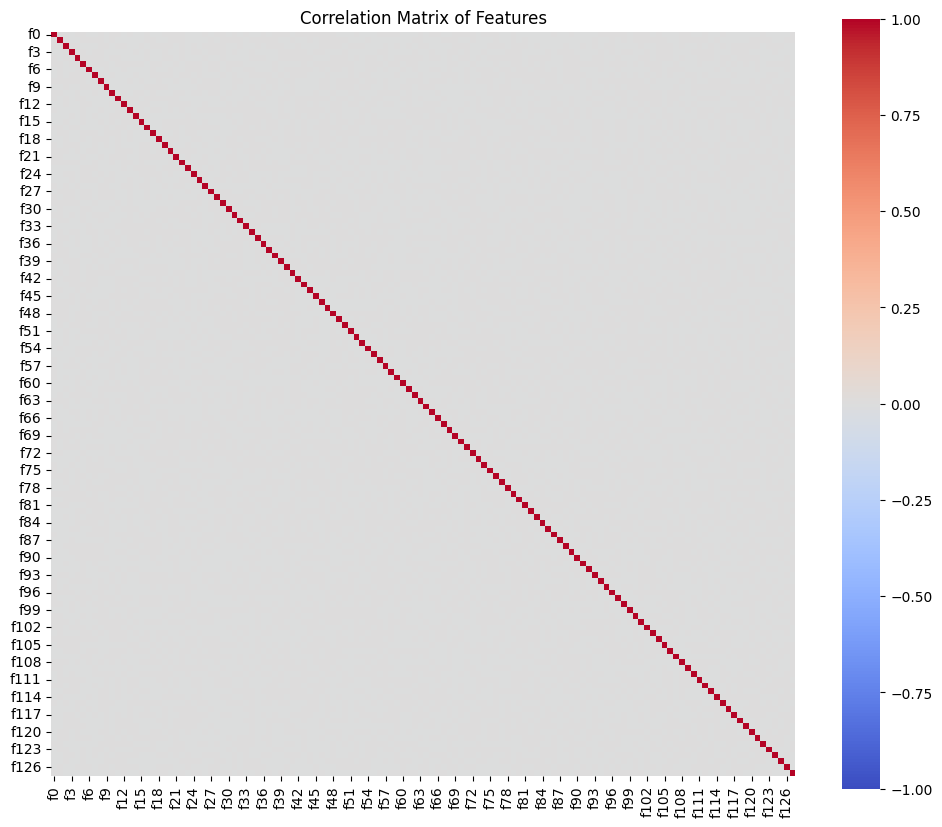

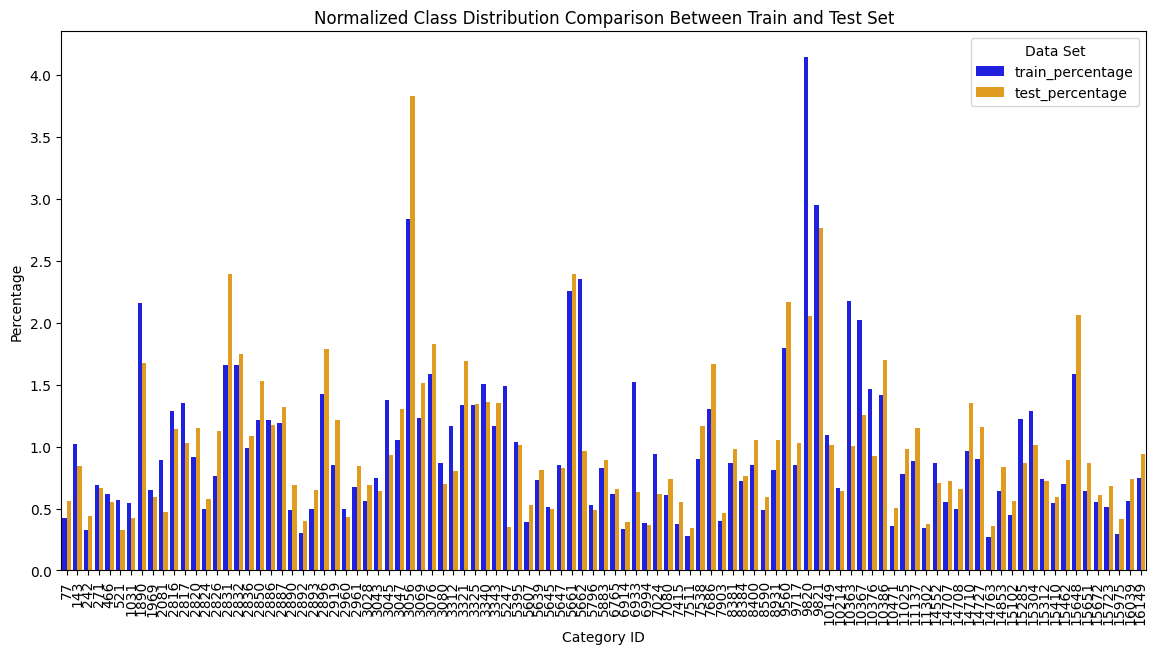

In [3]:
sanity_check(train_df, test_df)
plot_correlation_matrix(train_df)
plot_class_distribution_comparison(train_df, test_df)

## Methodology: Features Engineering

### Insights:

<u>Outliers:</u>
- Rows with more than 10% outlier features (z-score absolute threshold > 3) were removed, accounting for 2.91% of the training dataset.
    Analysis of row removal per category shows that no more than 10% of the data was removed for any category.

<u>Train, Validation & Test Split:</u>
- The training dataset was split into training and validation sets with a 0.8/0.2 ratio, ensuring stratification to maintain category distribution and random shuffling to prevent order bias.

<u>Scaling:</u>
- Standardization is applied to ensure features are on a similar scale, which helps improve model performance and convergence.

<u>Dimensionality Reduction:</u>
- PCA: Initial PCA suggests features are nearly orthogonal, requiring 120 features to explain 95% of the variance, with similar contributions from each feature.
    LassoCV: Removed 2 features, aiding in reducing overfitting and improving generalization.

<u>Feature Interaction:</u>
- No polynomial features were created due to high dimensionality. Decision trees and ensemble methods like Random Forests and Gradient Boosting capture feature interactions implicitly.

In [4]:
import numpy as np

from scipy.stats import zscore
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

RANDOM_SEED : int = 42
TRAIN_TEST_SPLIT: int = 0.2

def split_labels_from_features(df: pd.DataFrame):
    X = df.iloc[:, 2:]  # Features
    y = df["category_id"]  # Labels
    return X, y

def remove_outliers(df: pd.DataFrame, feature_columns: list, threshold: float, max_outliers_per_row: int) -> tuple[pd.DataFrame, pd.Series]:
    # Calculate z-scores for the specified feature columns & determine outliers
    z_scores = df[feature_columns].apply(zscore)
    outliers = (z_scores > threshold) | (z_scores < -threshold)
    
    # Count the number of outliers per row & filter rows with excessive outliers
    outliers_per_row = outliers.sum(axis=1) 
    filtered_df = df[outliers_per_row <= max_outliers_per_row]
    return filtered_df, outliers_per_row

def scale_features(X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame, scaler) -> tuple:
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled

def select_features_with_lasso(X_train_scaled: np.ndarray, y_train_encoded: np.ndarray, X_val_scaled: np.ndarray, X_test_scaled: np.ndarray) -> tuple:

    lasso_cv = LassoCV(cv=5, random_state=RANDOM_SEED)
    lasso_cv.fit(X_train_scaled, y_train_encoded)
    selected_features_mask = lasso_cv.coef_ != 0
    
    X_train_selected = X_train_scaled[:, selected_features_mask]
    X_val_selected = X_val_scaled[:, selected_features_mask]
    X_test_selected = X_test_scaled[:, selected_features_mask]

    return X_train_selected, X_val_selected, X_test_selected, selected_features_mask

def print_summary(original_df: pd.DataFrame, filtered_df: pd.DataFrame, selected_features_mask: np.ndarray, X_train: pd.DataFrame):
    # Dataset shape information
    original_size = original_df.shape
    filtered_size = filtered_df.shape
    rows_removed = original_size[0] - filtered_size[0]
    
    print(f"Original dataset size: {original_size[0]} rows x {original_size[1]} columns")
    print(f"Filtered dataset size: {filtered_size[0]} rows x {filtered_size[1]} columns")
    print(f"Number of rows removed due to outliers: {rows_removed} ({100 * rows_removed / original_size[0]:.2f}%)")
    
    # Feature selection information
    num_selected_features = selected_features_mask.sum()
    selected_features = X_train.columns[selected_features_mask]
    
    print(f'Number of selected features after LassoCV: {num_selected_features}')

def plot_outliers_distribution(outliers_per_row):
    plt.figure(figsize=(10, 6))
    sns.histplot(outliers_per_row, kde=True, bins=30, color='skyblue')
    plt.title('Distribution of Outliers per Row', fontsize=16)
    plt.xlabel('Number of Outliers per Row', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.show()

def plot_category_removal_percentage(original_df: pd.DataFrame, filtered_df: pd.DataFrame):
    initial_category_counts = original_df["category_id"].value_counts()
    filtered_category_counts = filtered_df["category_id"].value_counts()
    
    # Align counts
    aligned_counts = pd.concat([initial_category_counts, filtered_category_counts], axis=1, keys=['Before', 'After']).fillna(0)
    aligned_counts['% Removed'] = (aligned_counts['Before'] - aligned_counts['After']) / aligned_counts['Before'] * 100
    aligned_counts_sorted = aligned_counts.sort_values('% Removed', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=aligned_counts_sorted.index, y=aligned_counts_sorted['% Removed'], palette='coolwarm')
    plt.xticks(rotation=90)
    
    plt.title('Percentage of Rows Removed per Product Category', fontsize=16)
    plt.xlabel('Product Category', fontsize=14)
    plt.ylabel('% of Rows Removed', fontsize=14)
    
    plt.tight_layout()
    plt.show()

Original dataset size: 241483 rows x 130 columns
Filtered dataset size: 234446 rows x 130 columns
Number of rows removed due to outliers: 7037 (2.91%)
Number of selected features after LassoCV: 126


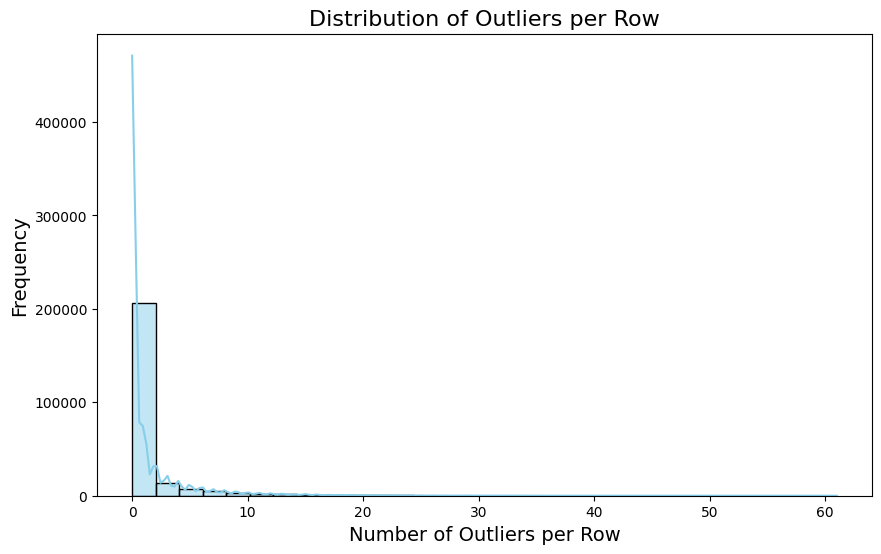

/tmp/ipykernel_39813/3377797247.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aligned_counts_sorted.index, y=aligned_counts_sorted['% Removed'], palette='coolwarm')


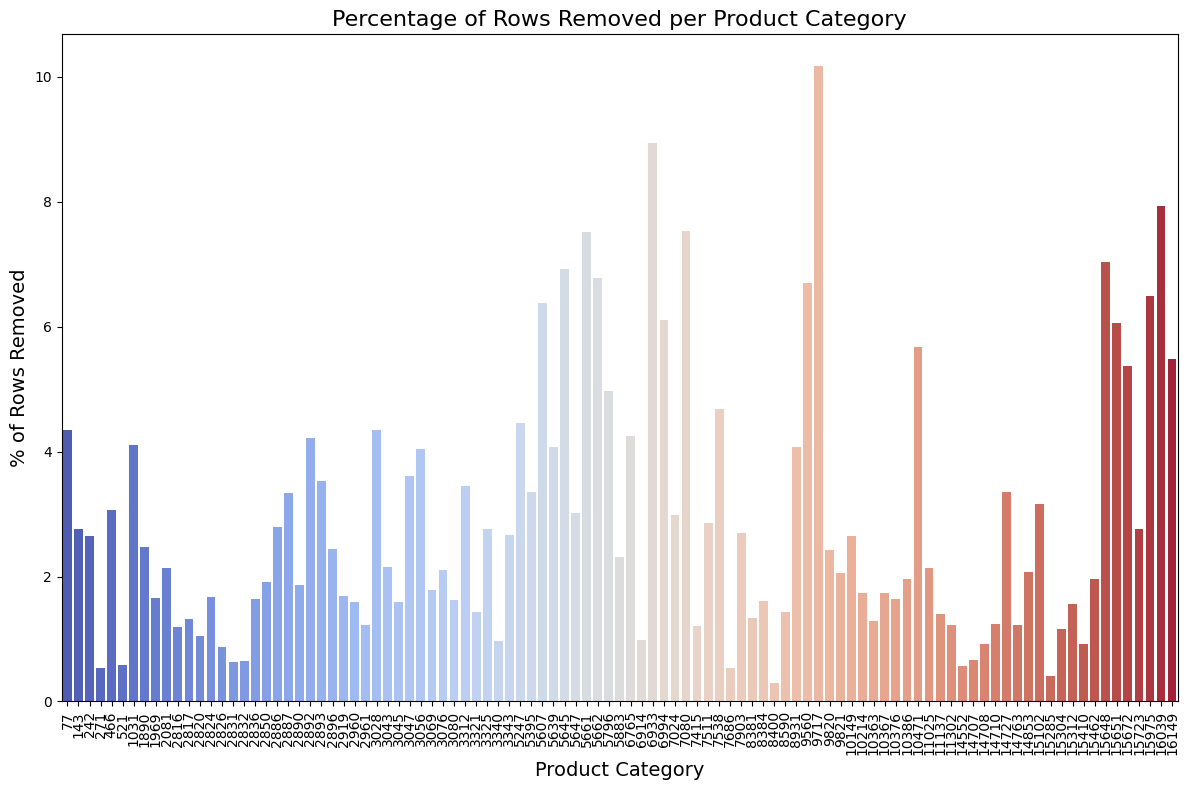

In [5]:
Z_SCORE_OUTLIERS_THRESHOLD: int = 3
MAX_OUTLIERS_PER_ROW: int = 10

# outliers
feature_columns = train_df.columns[2:]
filtered_train_df, outliers_per_row = remove_outliers(train_df, feature_columns, Z_SCORE_OUTLIERS_THRESHOLD, MAX_OUTLIERS_PER_ROW)

# split the data
X_test, y_test = split_labels_from_features(test_df)
X, y = split_labels_from_features(filtered_train_df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TRAIN_TEST_SPLIT, shuffle=True, stratify=y, random_state=RANDOM_SEED)

# encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)

# scale data
scaler = StandardScaler()  # or RobustScaler()
X_train_scaled, X_val_scaled, X_test_scaled = scale_features(X_train, X_val, X_test, scaler)

# features selection with Lasso
X_train_selected, X_val_selected, X_test_selected, selected_features_mask = select_features_with_lasso(X_train_scaled, y_train_encoded, X_val_scaled, X_test_scaled)

print_summary(train_df, filtered_train_df, selected_features_mask, X_train)
plot_outliers_distribution(outliers_per_row)
plot_category_removal_percentage(train_df, filtered_train_df)

## Methodology: Modeling


Baseline linear model ->
<u>Classification Algorithms</u>
- Logistic Regression: A straightforward linear classifier that's efficient for high-dimensional data and handles class imbalance with class weighting.
- Ridge Classifier: An extension of Logistic Regression with L2 regularization, helping to prevent overfitting in high-dimensional spaces.
- RandomForest Classifier: An ensemble method that combines multiple decision trees, reducing overfitting and performing well with high-dimensional data.
- XGBoost/LightGbm: A powerful gradient boosting algorithm that builds trees sequentially and includes parameters for addressing class imbalance.
- Support Vector Machine (SVM): Effective for high-dimensional data, with the ability to capture complex relationships using different kernels, though it requires careful tuning for class imbalance.

In [6]:
from typing import Tuple, Optional
from sklearn.metrics import classification_report
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier

def get_classification_report_df(model, X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    y_pred = model.predict(X)
    return pd.DataFrame(classification_report(y, y_pred, output_dict=True)).transpose()

def score_model(model, X_train: pd.DataFrame, X_val: pd.DataFrame, X_test: pd.DataFrame, 
                y_train: pd.Series, y_val: pd.Series, y_test: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Predict and evaluate on training data
    train_report_df = get_classification_report_df(model, X_train, y_train)
    print("Training data classification report F1-score:")
    print(train_report_df.loc[:, "f1-score"].mean())

    # Predict and evaluate on validation data
    val_report_df = get_classification_report_df(model, X_val, y_val)
    print("Validation data classification report F1-score:")
    print(val_report_df.loc[:, "f1-score"].mean())

    # Predict and evaluate on test data
    test_report_df = get_classification_report_df(model, X_test, y_test)
    print("Test data classification report F1-score:")
    print(test_report_df.loc[:, "f1-score"].mean())
    
    return train_report_df, val_report_df, test_report_df

def plot_f1_vs_support_percentage(df_report: pd.DataFrame) -> None:
    # Filter out 'accuracy', 'macro avg', 'weighted avg'
    df_report = df_report.iloc[:-3, :]
    
    # Calculate percentages for the support values
    total_instances = df_report['support'].sum()
    df_report['support_percentage'] = (df_report['support'] / total_instances) * 100
    
    # Plotting F1-score vs Support Percentage
    plt.figure(figsize=(10, 6))
    plt.scatter(df_report['support_percentage'], df_report['f1-score'], color='blue', alpha=0.7)
    plt.title("Relationship between Support Percentage and F1-Score for Each Class", fontsize=16)
    plt.xlabel("Support (Percentage of Total Instances)", fontsize=14)
    plt.ylabel("F1-Score", fontsize=14)
    
    # Optionally, annotate each point with the class label
    for i, class_label in enumerate(df_report.index):
        plt.annotate(class_label, (df_report['support_percentage'].iloc[i], df_report['f1-score'].iloc[i]),
                     textcoords="offset points", xytext=(0,5), ha='center', fontsize=9)
    
    plt.grid(True)
    plt.show()

def compare_f1_scores(report_dict1: pd.DataFrame, report_dict2: pd.DataFrame, 
                      model1_name: str, model2_name: str) -> None:
    # Convert classification report dictionaries to DataFrames
    df1 = report_dict1.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
    df2 = report_dict2.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
    
    # Concatenate F1-scores for all models
    f1_df = pd.concat([df1[['f1-score']].rename(columns={'f1-score': model1_name}),
                       df2[['f1-score']].rename(columns={'f1-score': model2_name})], axis=1)
    
    # Plot the comparison of F1-scores
    f1_df.plot(kind='bar', figsize=(12, 6))
    plt.title('F1-Score Comparison per Class')
    plt.ylabel('F1-Score')
    plt.xlabel('Class')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

Training data classification report F1-score:
0.5795005066061456
Validation data classification report F1-score:
0.5801476169730113
Test data classification report F1-score:
0.5630624188847799


/tmp/ipykernel_39813/344242129.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_report['support_percentage'] = (df_report['support'] / total_instances) * 100


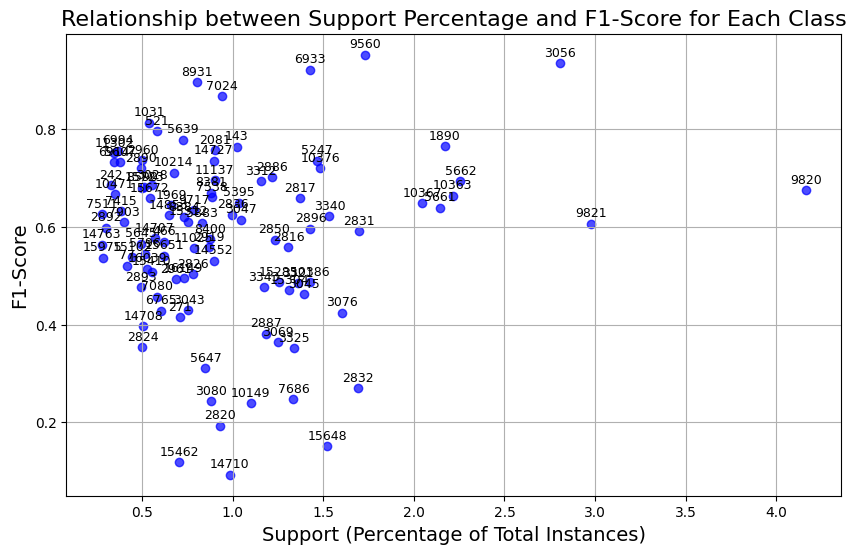

In [7]:
ridge_clf = RidgeClassifier(class_weight="balanced", random_state=RANDOM_SEED)
ridge_clf.fit(X_train_selected, y_train)

ridge_clf_train_report_df, ridge_clf_validation_report_df, ridge_clf_test_report_df = score_model(
    ridge_clf, X_train_selected, X_val_selected, X_test_selected, y_train, y_val, y_test
)
plot_f1_vs_support_percentage(ridge_clf_validation_report_df)

/home/nicolas/code/mirakl/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training data classification report F1-score:
0.6615887037686127
Validation data classification report F1-score:
0.6354860425944537
Test data classification report F1-score:
0.6223140387608329


/tmp/ipykernel_39813/344242129.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_report['support_percentage'] = (df_report['support'] / total_instances) * 100


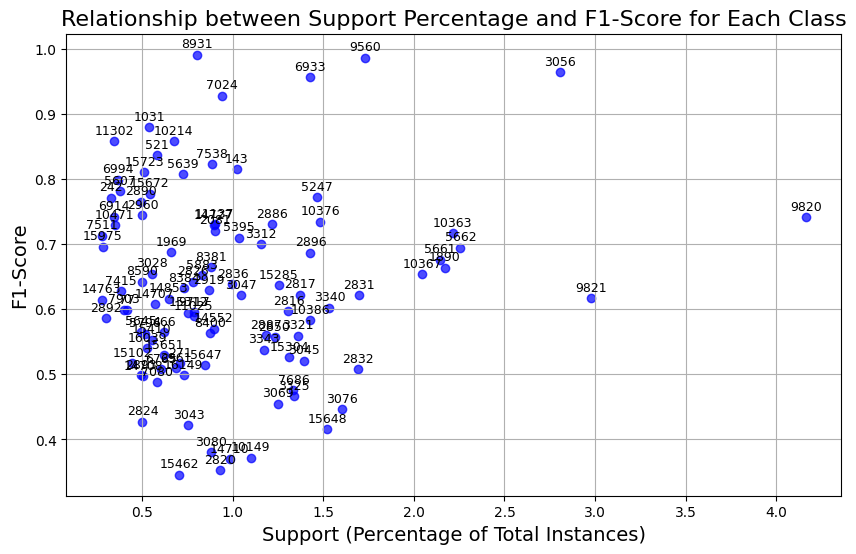

In [8]:
log_reg = LogisticRegression(class_weight="balanced", random_state=RANDOM_SEED)
log_reg.fit(X_train_selected, y_train)

log_reg_train_report_df, log_reg_validation_report_df, log_reg_test_report_df = score_model(
    log_reg, X_train_selected, X_val_selected, X_test_selected, y_train, y_val, y_test
)
plot_f1_vs_support_percentage(log_reg_validation_report_df)

In [ ]:
decision_tree_args = {"max_depth": 25, "min_samples_split": 40, "min_samples_leaf":20}
dt_clf = DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_SEED, **decision_tree_args)
dt_clf.fit(X_train_selected, y_train)

dt_clf_train_report_df, dt_clf_validation_report_df, dt_clf_test_report_df = score_model(
    dt_clf, X_train_selected, X_val_selected, X_test_selected, y_train, y_val, y_test
)
plot_f1_vs_support_percentage(dt_clf_validation_report_df)